## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

##Imports

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from IPython.display import Image

##Define parameters & data loading

In [ ]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 2
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    #device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"

if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

100%|██████████| 170498071/170498071 [00:04<00:00, 42595135.43it/s]


Extracting data/cifar-10-python.tar.gz to data


Label:  6


(array([ 2.,  5., 32., 80., 75., 20., 11., 17., 44., 64., 76., 23.,  6.,
        17., 32., 51., 77., 39.,  2.,  2.]),
 array([-0.87450981, -0.82078433, -0.76705885, -0.71333331, -0.65960783,
        -0.60588235, -0.55215687, -0.49843135, -0.44470587, -0.39098036,
        -0.33725488, -0.2835294 , -0.22980389, -0.17607841, -0.12235291,
        -0.06862742, -0.01490192,  0.03882357,  0.09254906,  0.14627455,
         0.20000005]),
 <BarContainer object of 20 artists>)

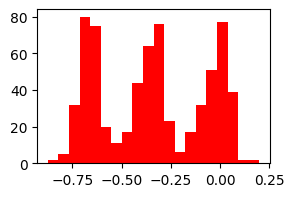

In [ ]:
img, labels = cifar_dataset[0]
print("Label: ", labels)
plt.figure(figsize = (3,2))
plt.hist(img[:, 5:20, 5:20].flatten(), bins=20, color = 'red')

torch.Size([3, 64, 64])


(array([ 2.,  5., 32., 80., 75., 20., 11., 17., 44., 64., 76., 23.,  6.,
        17., 32., 51., 77., 39.,  2.,  2.]),
 array([0.06274509, 0.08960784, 0.11647059, 0.14333333, 0.17019609,
        0.19705883, 0.22392157, 0.25078431, 0.27764708, 0.30450982,
        0.33137256, 0.3582353 , 0.38509804, 0.41196081, 0.43882355,
        0.46568629, 0.49254903, 0.5194118 , 0.54627454, 0.57313728,
        0.60000002]),
 <BarContainer object of 20 artists>)

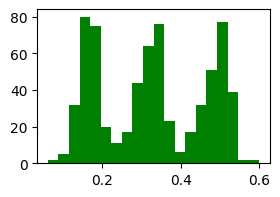

In [ ]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denormaliz(img):
    res = torch.clamp(((img + 1) / 2), 0, 1)
    return res

print(img.shape)
# show image sample with matplotlib
plt.figure(figsize = (3,2))
plt.hist(denormaliz(img)[:, 5:20, 5:20].flatten(), bins = 20, color = 'green')

In [ ]:
# create the dataloader
dataload = DataLoader(dataset = cifar_dataset, batch_size = CFG.batch_size, shuffle = True, num_workers= CFG.workers, drop_last = True)
features, label = next(iter(dataload))
print(features.shape, label.shape)

torch.Size([128, 3, 64, 64]) torch.Size([128])


### DCGAN implementation

In the generator class, we will use the torch.nn.Conv2d class, which applies 2D convolution to an input signal consisting of several input planes.
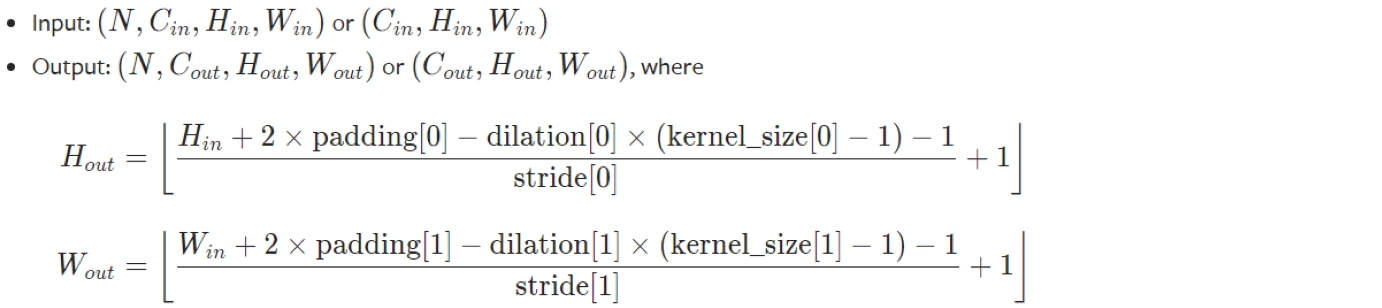

In the discriminator class, we use the torch.nn.ConvTranspose2d module, which applies a two-dimensional transposed convolution operator to an input image consisting of several input planes.
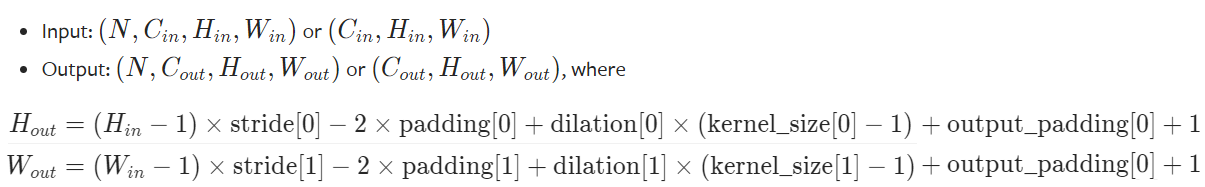

In [ ]:
class Generator(nn.Module):
    def __init__(self, nc: int = 3, nz: int = 100, ngf: int = 64):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False), #accepts a tensor of size [batch_size, nz, 1, 1] as input and returns a tensor of size [batch_size, ngf * 8, 4, 4]
            nn.BatchNorm2d(ngf * 8), #batch normalization layer that accepts a tensor of the size [batch_size, ngf*8, 4, 4] as input and returns a tensor of the same size
            nn.ReLU(), #non-linear ReLU activation layer
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias = False), #accepts a tensor of size [batch_size, ngf * 8, 4, 4] as input and returns a tensor of size [batch_size, ngf * 4, 8, 8]
            nn.BatchNorm2d(ngf * 4), #batch normalization layer that accepts a tensor of size [batch_size, ngf * 4, 8, 8] as input and returns a tensor of the same size
            nn.ReLU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
            nn.ConvTranspose2d(ngf, nc, kernel_size = 4, stride = 2, padding = 1, bias = False), #accepts a tensor of size [batch_size, ngf, 32, 32] as input and returns a tensor of size [batch_size, nc, 64, 64]
            nn.Tanh()
            # result size: [batch_size, nc, 64, 64]
        )

    def forward(self, x):
        output = self.main(x)
        return output


class Discriminator(nn.Module):
    def __init__(self, nc: int = 3, ndf: int = 64):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky -
        # conv2d - batchnorm - leaky - conv2d - sigmoid
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size = 4, stride = 2, padding = 1, bias = False), #accepts an input tensor of size [nc, 64, 64] , the result is a tensor of size [ndf, 32, 32]
            nn.LeakyReLU(0.1, inplace = True), #an activation function that applies the LeakyReLU function with a slope of 0.1 to the output of the first convolutional layer
            nn.Conv2d(ndf, ndf * 2, kernel_size = 4, stride = 2, padding=1, bias = False), # scans an external tensor of size [ndf, 32, 32] , resulting in a tensor of size [ndf * 2, 16, 16]
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.1, inplace = True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size = 4, stride = 2, padding=1, bias = False), # res: [ndf * 4, 8, 8]
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.1, inplace = True),
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size = 4, stride = 2, padding=1, bias = False), # res: [ndf * 8, 4, 4]
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.1, inplace = True),
            nn.Conv2d(ndf * 8, 1, kernel_size = 4, stride = 1, padding = 0, bias = False), #accepts an input tensor of size [ndf * 8, 4, 4], the result is a tensor of size [1, 1, 1]
            nn.Sigmoid() #an activation function that applies a sigmoid to the output of the fifth convolutional layer
        )

    def forward(self, x):
        output = self.main(x)
        return output

#from models import Generator, Discriminator
DCG = Generator().to(CFG.device) # create new Generator model
DCD = Discriminator().to(CFG.device) # create new Discriminator model
print(DCG, DCD)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
) Discriminator(
  (main): Sequential(
    (0): Co

##Create the Generator and Discriminator

In [ ]:
# show the output of model
y = DCG(torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device))
b = DCD(torch.randn(CFG.batch_size, CFG.nc, 64, 64).to(CFG.device))
print(y.shape, b.shape)

torch.Size([128, 3, 64, 64]) torch.Size([128, 1, 1, 1])


(64, 64, 3)


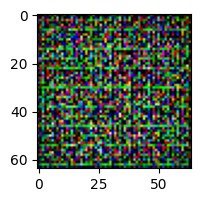

In [ ]:
img = y[0]
img = img.permute(1, 2, 0).to("cpu").detach().numpy()
plt.figure(figsize = (3,2))
plt.imshow(img)
print(img.shape)

In [ ]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()

## define the optimizer for generator and discrimator
d_opt = torch.optim.Adam(params = DCD.parameters(), lr = CFG.lr)
g_opt = torch.optim.Adam(params = DCG.parameters(), lr = CFG.lr)

## reset gradient for optimizer of generator and discrimator
def reset_grad():
    g_opt.zero_grad()
    d_opt.zero_grad()

##Train discriminator and generator

In [ ]:
def train_discriminator(D_model, G_model, images):

    DCD.zero_grad() # Reset gradients

    # Create the labels which are later used as input for the BCEloss
    real_mark = 1
    fake_mark = 0

    images = images.reshape(batch_size, 3, image_size, image_size).to(device)
    b_size = images.size(0)

    mark = torch.full((b_size,), real_mark, dtype=torch.float, device=device).view(-1)
    outputs = D_model(images).view(-1)

    # Loss for real images
    d_loss_real_score = criterion(outputs, mark)
    d_loss_real_score.backward()
    real_score = outputs

    # Loss for fake images
    z = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = G_model(z)
    mark.fill_(fake_mark)
    outputs = D_model(fake_images.detach()).view(-1)

    d_loss_fake_score = criterion(outputs, mark) # Using the BCEloss function
    d_loss_fake_score.backward()
    fake_score = outputs

    d_loss = d_loss_real_score + d_loss_fake_score # Sum losses
    d_opt.step() # Adjust the parameters using backprop

    return d_loss, real_score, fake_score

def train_generator(G_model):
    # Generate fake images and calculate loss
    real_mark = 1
    b_size = images.size(0)
    mark = torch.full((b_size,), real_mark, dtype=torch.float, device=device)
    mark.fill_(real_mark)

    z = torch.Tensor(np.random.normal(0, 1, (CFG.batch_size, CFG.nz, 1, 1))).to(CFG.device)
    fake_images = G_model(z)
    outputs = DCD(fake_images).view(-1)

    g_loss = criterion(outputs, mark) # Using the BCEloss function
    reset_grad() # Reset gradients

    g_loss.backward() # Backprop and optimize
    g_opt.step()

    return g_loss, fake_images

##Start the training proccess and save images

In [ ]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_imag = DCG_model(sample_vectors)
    fake_imag = fake_imag.reshape(fake_imag.size(0), 3, 64, 64)
    fake_fname = "fake_images-{:d}.png".format(index)
    save_image(denormaliz(fake_imag), os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [ ]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size
nc = CFG.nc
nz = CFG.nz
image_size = CFG.image_size

total_step = len(dataload)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataload):

        # Load a batch & transform to vectors
        images = images.reshape(128, -1, image_size, image_size).to(device)

        d_loss, real_score, fake_score = train_discriminator(D_model = DCD, G_model = DCG, images = images) # Train the discriminator
        g_loss, fake_images = train_generator(G_model = DCG) # Train the generator

        # Inspect the losses
        if (i + 1) % 300 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.6f}, D(G(z)): {:.6f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )

    # Sample and save images
    save_fake_images_cifar(DCG_model = DCG, index = epoch + 1)

Epoch [0/300], Step [300/390], d_loss: 0.0381, g_loss: 12.3532, D(x): 0.974381, D(G(z)): 0.002767
Epoch [1/300], Step [300/390], d_loss: 0.0965, g_loss: 13.4224, D(x): 0.946076, D(G(z)): 0.000106
Epoch [2/300], Step [300/390], d_loss: 0.0135, g_loss: 10.4753, D(x): 0.987961, D(G(z)): 0.000601
Epoch [3/300], Step [300/390], d_loss: 0.0420, g_loss: 5.5680, D(x): 0.999401, D(G(z)): 0.036139
Epoch [4/300], Step [300/390], d_loss: 0.0309, g_loss: 11.6254, D(x): 0.999964, D(G(z)): 0.026812
Epoch [5/300], Step [300/390], d_loss: 0.0030, g_loss: 9.3981, D(x): 0.999574, D(G(z)): 0.002605
Epoch [6/300], Step [300/390], d_loss: 0.0291, g_loss: 13.2510, D(x): 0.973029, D(G(z)): 0.000226
Epoch [7/300], Step [300/390], d_loss: 0.0861, g_loss: 9.2973, D(x): 0.934508, D(G(z)): 0.005756
Epoch [8/300], Step [300/390], d_loss: 0.0051, g_loss: 10.6593, D(x): 0.995595, D(G(z)): 0.000510
Epoch [9/300], Step [300/390], d_loss: 0.1470, g_loss: 10.5723, D(x): 0.999655, D(G(z)): 0.103529
Epoch [10/300], Step [3

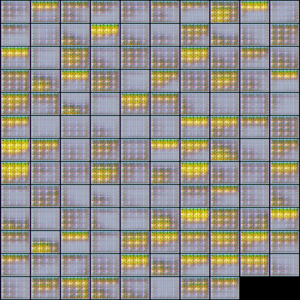

In [ ]:
from PIL import Image
out_img = Image.open(os.path.join(CFG.sample_dir, "fake_images-1.png"))
out_img.resize((300, 300))

In [ ]:
def display_imgSquare(a):
    new_im = []
    for i in a:
        with Image.open(os.path.join(CFG.sample_dir, f"fake_images-{i}.png")) as img:
            img = img.resize((200, 200))
            new_im.append(img)

    result = Image.new('RGB', (new_im[0].width * 2, new_im[0].height * 2), color='white')
    result.paste(new_im[0], (0, 0))
    result.paste(new_im[1], (new_im[0].width, 0))
    result.paste(new_im[2], (0, new_im[0].height))
    result.paste(new_im[3], (new_im[0].width, new_im[0].height))
    return result

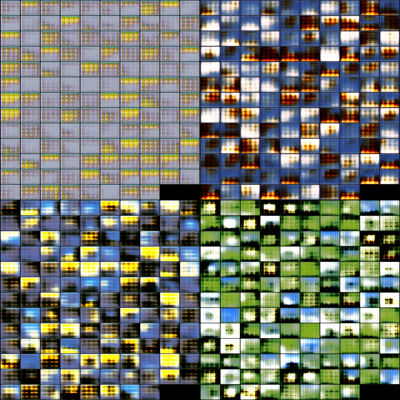

In [ ]:
display_imgSquare([1, 2, 3, 4])

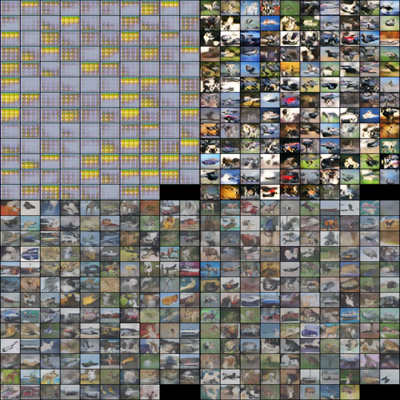

In [ ]:
display_imgSquare([1,50,100,150])

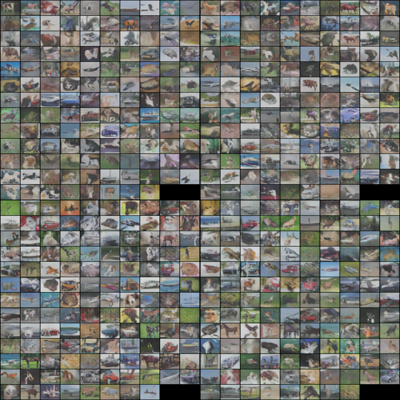

In [ ]:
display_imgSquare([150,200,250,300])

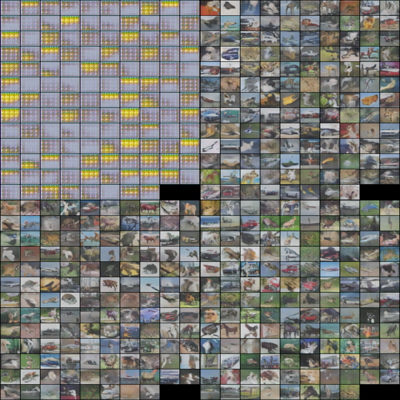

In [ ]:
display_imgSquare([1,100,200,300])

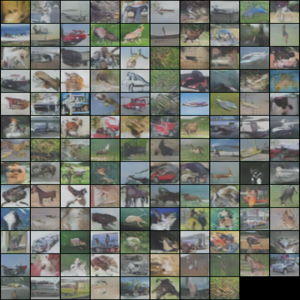

In [ ]:
from PIL import Image
out_img = Image.open(os.path.join(CFG.sample_dir, "fake_images-300.png"))
out_img.resize((300, 300))

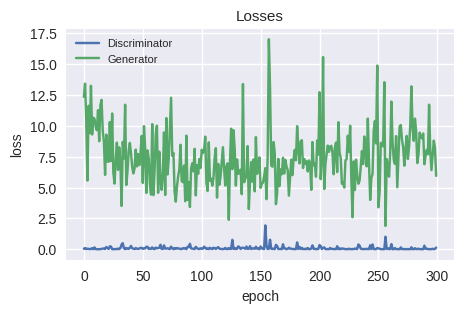

In [ ]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(5,3))
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch", fontsize = 10)
plt.ylabel("loss", fontsize = 10)
plt.legend(["Discriminator", "Generator"], fontsize = 8)
plt.title("Losses", fontsize = 11);

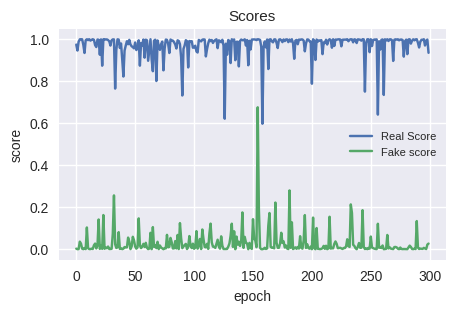

In [ ]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(5,3))
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch", fontsize = 10)
plt.ylabel("score", fontsize = 10)
plt.legend(["Real Score", "Fake score"], fontsize = 8)
plt.title("Scores", fontsize = 11);